# imports

In [98]:
# 初始化整個實驗環境
import sys
sys.path.append("C:/Users/GAI/Desktop/Scott/NCA_Research")

from E4_PI_NCA.init_notebook_imports import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
set_global_seed(1234)

Using device: cuda
[INFO] Global seed set to 1234


# helper functions

chair
    component
        train
        test
    object
        2d
        3d
            train
            test

chair
    train
        component
        3d
        2d
    test
        component
        3d
        2d

In [99]:
from PIL import Image
import torch
import torchvision.transforms as T


# ================================================================
# 讀取 PNG、調整大小、轉成 Torch Tensor（CHW 格式）
# ================================================================
def read_png_to_chw_tensor(path: str, size: tuple[int, int] = None) -> torch.Tensor:
    """
    讀取 PNG 並轉換成 [C, H, W] torch.Tensor
    - size: 目標總尺寸 (含 padding)
    - pad: 邊界補零像素數
    """
    # ------------------------------------------------------------
    # 1. 讀取圖片並轉成 RGBA
    # ------------------------------------------------------------
    img = Image.open(path).convert("RGBA")

    # ------------------------------------------------------------
    # 2. 先縮小到 (W - 2*pad, H - 2*pad)
    # ------------------------------------------------------------
    if size is not None:
        img = img.resize(size, Image.NEAREST)

    # ------------------------------------------------------------
    # 3. 套用 alpha 通道遮罩（避免背景殘留）
    # ------------------------------------------------------------
    img_np = np.array(img).astype(np.float32) / 255.0  # [H, W, 4]
    alpha = img_np[..., 3:4]
    img_np *= alpha  # 套用透明度

    # ------------------------------------------------------------
    # 4. 轉成 tensor [C, H, W]
    # ------------------------------------------------------------
    tensor = torch.from_numpy(img_np.transpose(2, 0, 1))  # [3, H, W]

    return tensor


# ================================================================
# 隨機四邊 padding（兩個 pool 對應一致）
# ================================================================
def random_pad_pair(
    poolA: torch.Tensor, poolB: torch.Tensor, min_pad: int = 10, max_pad: int = 10
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    對兩個 [B, C, H, W] tensor：
      - 每個 batch 隨機產生上下左右 pad（0~max_pad）
      - 使用相同 pad 對 A/B 處理
      - 最後 resize 回原始 H, W 大小

    Returns:
        paddedA, paddedB: torch.Tensor，大小同原始 pool
    """
    B, C, H, W = poolA.shape
    paddedA_list, paddedB_list = [], []

    for b in range(B):
        # 隨機 pad 數值
        pad_left = random.randint(min_pad, max_pad)
        pad_right = random.randint(min_pad, max_pad)
        pad_top = random.randint(min_pad, max_pad)
        pad_bottom = random.randint(min_pad, max_pad)

        pad_tuple = (pad_left, pad_right, pad_top, pad_bottom)

        # pad
        a_padded = F.pad(poolA[b], pad_tuple, mode="constant", value=0)
        b_padded = F.pad(poolB[b], pad_tuple, mode="constant", value=0)

        # resize 回原始大小
        a_resized = F.interpolate(
            a_padded.unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False
        ).squeeze(0)
        b_resized = F.interpolate(
            b_padded.unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False
        ).squeeze(0)

        paddedA_list.append(a_resized)
        paddedB_list.append(b_resized)

    paddedA = torch.stack(paddedA_list, dim=0)
    paddedB = torch.stack(paddedB_list, dim=0)
    return paddedA, paddedB


def create_seed_pool(pool: torch.Tensor) -> torch.Tensor:
    """
    給定 BCHW tensor，根據 channel=3 (alpha 通道) 計算 alpha=1 像素的重心，
    回傳一個新的全 0 tensor（同 shape），
    並在每個 batch 的 channel=3、重心 pixel 位置設為 1.0。
    """
    B, C, H, W = pool.shape
    new_pool = torch.zeros_like(pool)

    # 取出 alpha 通道 [B, 1, H, W]
    alpha = pool[:, 3:4, :, :]

    for b in range(B):
        # 找出 alpha == 1 的像素座標
        mask = (alpha[b, 0] == 1.0)
        if mask.sum() == 0:
            continue  # 若沒有 alpha=1 就跳過

        ys, xs = torch.nonzero(mask, as_tuple=True)

        # 計算重心（平均座標）
        cy = torch.mean(ys.float())
        cx = torch.mean(xs.float())

        # 四捨五入取最近 pixel
        cy = int(round(cy.item()))
        cx = int(round(cx.item()))

        # 安全界線檢查
        cy = max(0, min(H - 1, cy))
        cx = max(0, min(W - 1, cx))

        # 在 new_pool 中標記重心 pixel
        pad = 4
        new_pool[b, 3, cy-pad:cy+pad, cx-pad:cx+pad] = 1.0

    return new_pool



def create_pools_from_img_path(config: dict)->tuple[torch.Tensor,torch.Tensor]:
    path = config["system"]["img_path"]
    B = config["dataset"]["final_epoch_size"]
    C = config["model"]["channels"]
    H = config["dataset"]["img_size"]
    W = config["dataset"]["img_size"]
    
    chw = read_png_to_chw_tensor(path, size=(H,W))  # [3, 128, 128]
    # 建立空的 pool，假設共 B 個樣本與 C 通道
    y_pool = torch.zeros((B, C, H, W), dtype=torch.float32)
    x_pool = torch.zeros((B, C, H, W), dtype=torch.float32)
    # 將圖片放入前 3 個通道
    y_pool[:, :4, :, :] = chw
    x_pool = create_seed_pool(y_pool)

    x_pool, y_pool = random_pad_pair(x_pool, y_pool, min_pad=5, max_pad=100)
    return x_pool, y_pool


In [100]:
def init_X(config: dict, y_pool: torch.Tensor) -> torch.Tensor:
    B, C, H, W = y_pool.shape
    x_pool = torch.zeros((B, C, H, W), dtype=torch.float32)

    # 取出 alpha 通道 [B, 1, H, W]
    alpha = y_pool[:, 3:4, :, :]

    for b in range(B):
        # 找出 alpha == 1 的像素座標
        mask = (alpha[b, 0] == 1.0)
        if mask.sum() == 0:
            continue  # 若沒有 alpha=1 就跳過

        ys, xs = torch.nonzero(mask, as_tuple=True)

        # 計算重心（平均座標）
        cy = torch.mean(ys.float())
        cx = torch.mean(xs.float())

        # 四捨五入取最近 pixel
        cy = int(round(cy.item()))
        cx = int(round(cx.item()))

        # 安全界線檢查
        cy = max(0, min(H - 1, cy))
        cx = max(0, min(W - 1, cx))

        # 在 x_pool 中標記重心 pixel
        pad = 4
        x_pool[b, 3, cy-pad:cy+pad, cx-pad:cx+pad] = 1.0

    return x_pool

# define Neural Net

## model

In [101]:
class CAModel(nn.Module):
    """
    Cellular Automata Model (Conv + perception kernels)
    """
    def __init__(self, config:dict):
        super().__init__()
        self.channel_n = config["model"]["channels"]
        self.hidden_dim = config["model"]["hidden_dim"]
        self.kernel_count = config["model"]["kernel_count"]
        self.num_hidden_layers = config["model"]["num_hidden_layers"]

        # 建立 rule_block
        self.rule_block = self.build_rule_block(
            in_channels=self.channel_n * self.kernel_count,
            hidden_dim=self.hidden_dim,
            out_channels=self.channel_n,
            num_hidden_layers=self.num_hidden_layers 
        )

    def build_rule_block(self, in_channels: int, hidden_dim: int, out_channels: int, num_hidden_layers: int = 1) -> nn.Sequential:
        """
        建立 rule block 的 Conv + Tanh 結構
        """
        layers = [nn.Conv2d(in_channels, hidden_dim, kernel_size=1), nn.Tanh()]
        # layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1))
        # layers.append(nn.Tanh())
        # layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1))
        # layers.append(nn.Tanh())
        for _ in range(num_hidden_layers):
            layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1))
            layers.append(nn.Tanh())
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1))  #, bias=False
        # layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def perchannel_conv(self, x: torch.Tensor, filters: torch.Tensor) -> torch.Tensor:
        """
        對每個 channel 做 depthwise convolution
        x: [B, C, H, W]
        filters: [filter_n, Hf, Wf]
        return: [B, C * filter_n, H, W]
        """
        b, ch, h, w = x.shape
        device = x.device
        filters = filters.to(device)
        y = x.reshape(b * ch, 1, h, w)
        y = F.pad(y, [1, 1, 1, 1], mode='circular')
        y = F.conv2d(y, filters[:, None])
        y = y.reshape(b, -1, h, w)
        return y

    def perception(self, x: torch.Tensor) -> torch.Tensor:
        """
        定義感知 kernels: identity, sobel_x, sobel_y, laplacian
        """
        device = x.device
        ident = torch.tensor([[0.0, 0.0, 0.0],
                              [0.0, 1.0, 0.0],
                              [0.0, 0.0, 0.0]], device=device)
        sobel_x = torch.tensor([[-1.0, 0.0, 1.0],
                                [-2.0, 0.0, 2.0],
                                [-1.0, 0.0, 1.0]], device=device)
        lap = torch.tensor([[1.0, 2.0, 1.0],
                            [2.0, -12.0, 2.0],
                            [1.0, 2.0, 1.0]], device=device)
        lbm = torch.tensor([[1/36, 1/9, 1/36],
                            [1/9, 4/9, 1/9],
                            [1/36, 1/9, 1/36]], device=device)
        filters = torch.stack([ident, sobel_x, sobel_x.T, lap, lbm])
        return self.perchannel_conv(x, filters)
    

    def forward_pass(self, x: torch.Tensor) -> torch.Tensor:
        """
        單步更新
        """
        check_tensor_nan_inf(x,"model")
        y = self.perception(x)
        check_tensor_nan_inf(y,"model2")
        dx = self.rule_block(y)
        check_tensor_nan_inf(dx,"model3")
        no_change = x[:, :6, :, :]  # 前4 channel 保留
        updated = x + dx * x[:, 2:3, :, :]
        check_tensor_nan_inf(updated,"model4")
        return torch.cat([no_change, updated[:, 6:, :, :]], dim=1)

    def forward(self, x: torch.Tensor, n_times: int = 1) -> torch.Tensor:
        """
        多步迭代
        """
        for _ in range(n_times):
            x = self.forward_pass(x)
        return x


## EarlyStop

In [102]:
class EarlyStopper:
    """
    Early stopping helper
    """
    def __init__(self, config):
        self.patience = config["earlystop"]["patience"]
        self.min_delta = config["earlystop"]["delta"]
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def step(self, loss):
        if loss + self.min_delta < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


## epoch step

### train step

In [103]:
# ====== 訓練函式 ======
def train_one_epoch(
    config: dict,
    epoch_count: int,
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: nn.Module,
    Y_pool: np.array,
    X_pool: np.array,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    執行一個 epoch 的訓練迴圈，回傳最後一個 batch 的 loss 與對應資料。

    參數:
        model: nn.Module, 神經網路模型
        optimizer: PyTorch Optimizer
        loss_fn: nn.Module, 損失函數
        train_batch_size: int, 單次訓練的 batch 大小
        item_pool_repeats: int, 將 epoch pool 複製的次數
        repeats_per_epoch: int, 每個 epoch 重複迭代的次數
        rollout_min: int, 最小演化步數
        rollout_max: int, 最大演化步數

    回傳:
        tuple: (loss, Y_batch, X_batch, X_pred)
            - loss: torch.Tensor, 最後一個 batch 的 loss
            - Y_batch: torch.Tensor, 目標 batch
            - X_batch: torch.Tensor, 模型輸入 batch
            - X_pred: torch.Tensor, 模型輸出 batch
    """

    train_batch_size = config["training"]["batch_size"]
    rollout_max = config["training"]["rollout_max"]
    total_epochs = config["training"]["total_epochs"]

    model.train()

    # 隨機挑一個 batch
    idx = torch.randint(0, len(Y_pool) - train_batch_size + 1, (1,))
    Y_batch = Y_pool[idx : idx + train_batch_size].to(DEVICE)
    X_batch = X_pool[idx : idx + train_batch_size].to(DEVICE).clone()
    check_tensor_nan_inf([Y_batch, X_batch], "train step1")
    with torch.no_grad():
        batch_count = len(X_batch)
        X_batch[-batch_count // 4 :] = init_X(config, X_batch[-batch_count // 4 :])
        X_batch = X_batch.to(DEVICE)
    check_tensor_nan_inf([Y_batch, X_batch], "train step2")
    # 隨機決定演化步數
    # rollout_steps = get_rollout_times(
    #     epoch_count, max_epoch=total_epochs, max_n=rollout_max, scale=1
    # )
    rollout_steps=rollout_max

    # 前向傳播
    X_pred = model(X_batch, n_times=rollout_steps)
    check_tensor_nan_inf([X_pred], "train step3")
    # 更新pool
    X_pool[idx : idx + train_batch_size] = X_pred
    check_tensor_nan_inf([X_pool], "train step4")

    # 計算 loss 並反向傳播
    check_tensor_nan_inf([X_pred, Y_batch], "train step5")
    loss_dict = loss_fn(config, X_pred, Y_batch)
    check_tensor_nan_inf([loss_dict], "train step6")
    total_loss = sum(loss_dict.values())

    # 反向傳播更新梯度
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    Y_channels = Y_batch.shape[1]


    batch_dict = {
        "Y": Y_batch,
        "X0": X_batch,
        "X1": X_pred,
        "diff": Y_batch - X_pred[:,:Y_channels],
    }

    return loss_dict, batch_dict

### eval step

In [104]:
def evaluate_one_epoch(
    config: dict,
    y_pool: torch.Tensor,
    model: torch.nn.Module,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]],
    metric_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]] = None,
) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor], np.ndarray]:
    """
    在測試集上做評估，計算平均 loss 與 metric。
    """
    rollout_steps = config["training"]["rollout_max"]
    model.eval()
    total_loss_list = []
    X_batch_list = []
    X_pred_list = []
    metrics_list = []

    # 建立 epoch 的子區域池
    Y_batch = y_pool[0:1].to(DEVICE)  # eval 模式只取一個樣本
    X_batch = init_X(config, Y_batch).to(DEVICE)
    check_tensor_nan_inf([Y_batch, X_batch], "inside eval")

    rollout_steps = 20
    for _ in range(rollout_steps):
        X_batch_list.append(X_batch.clone())
        check_tensor_nan_inf([X_batch_list, X_batch], "inside eval2")
        X_batch = model(X_batch, n_times=1)
        X_pred_list.append(X_batch.clone())

        # 計算 loss
        check_tensor_nan_inf([Y_batch, X_batch], "inside eval3")
        loss_dict = loss_fn(config, X_batch, Y_batch)
        check_tensor_nan_inf(loss_dict, "inside eval4")
        total_loss = sum(loss_dict.values())
        total_loss_list.append(total_loss)

        # 計算 metric
        if metric_fn is not None:
            acc_metric = metric_fn(X_batch, Y_batch)
            metrics_list.append(acc_metric)

    x0 = torch.cat(X_batch_list, dim=0)
    x1 = torch.cat(X_pred_list, dim=0)
    y = Y_batch.repeat((rollout_steps, 1, 1, 1))

    metrics_array = np.array(metrics_list)
    Y_channels = y.shape[1]
    batch_dict = {
        "Y": y,
        "X0": x0,
        "X1": x1,
        "diff": y - x1[:,:Y_channels],
    }

    return loss_dict, batch_dict, metrics_array

## training loop

In [105]:

def save_checkpoint(model, optimizer, epoch, path):
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        path,
    )

In [106]:
from torch.optim.lr_scheduler import _LRScheduler


def run_training(
    config: dict,
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]],
    metric_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]] = None,
    lr_sched: Optional[_LRScheduler] = None,
    output_path: str = "./output",
) -> None:

    total_epochs = config["training"]["total_epochs"]
    save_interval = config["training"]["save_interval"]

    train_loss_log: list[float] = []
    eval_loss_log: list[float] = []
    eval_loss = 0
    eval_metrics: List[np.ndarray] = []

    early_stopper = EarlyStopper(config)
    X_Pool, Y_Pool = create_pools_from_img_path(config)
    X_Pool=X_Pool.to(DEVICE)
    Y_Pool=Y_Pool.to(DEVICE)

    check_tensor_nan_inf([Y_Pool, X_Pool], "init_check")

    for epoch in trange(total_epochs, desc="Training Epochs"):
        # print(f"epoch {epoch} start ------------------------------------")
        # ===== Training step =====
        train_loss_dict, train_batch_dict = train_one_epoch(
            config, epoch, model, optimizer, loss_fn, Y_Pool, X_Pool
        )
        train_loss = sum(train_loss_dict.values())
        train_loss_log.append(train_loss.item())

        if lr_sched is not None:
            lr_sched.step()

        # ===== Eval step =====
        with torch.no_grad():
            check_tensor_nan_inf([X_Pool, Y_Pool], "eval check")
            X_Pool, Y_Pool = sort_pool_by_mse(X_Pool, Y_Pool)
            check_tensor_nan_inf([X_Pool, Y_Pool], "eval check2")
            eval_loss_dict, eval_batch_dict, eval_metric = evaluate_one_epoch(
                config, Y_Pool, model, loss_fn, metric_fn
            )
            check_tensor_nan_inf(
                [eval_loss_dict, eval_batch_dict, eval_metric], "eval check3"
            )
            eval_metrics.append(eval_metric)
            if len(eval_metrics) > 1000:  # 或自己決定長度
                eval_metrics.pop(0)

            eval_loss = sum(eval_loss_dict.values())
            eval_loss_log.append(eval_loss.item())


        # ===== Visualization & Logging =====
        if (epoch + 1) % 50 == 0:
            clear_output(wait=True)
            print_loss_dict(train_loss_dict, eval_loss_dict)
            viz_loss(
                train_loss_log, eval_loss_log, log_scale=True, window=total_epochs // 20
            )
            plt_acc_over_time(eval_metrics, title="L2 Metric", ylabel="L2 Error")
            print("train epoch")
            viz_batch_channels(train_batch_dict, show_channels=(5,10))
            viz_batch_samples(train_batch_dict, channel_start=6)
            # plot_HW3(to_HWC(Y_Pool[0,6:9]))
            # plot_HW3(to_HWC(train_batch_dict["X0"][0,6:9]))
            viz_pool(X_Pool[:, 6:9, :, :], step_i=epoch)
            # viz_batch_channels(eval_batch_dict)

        # ===== Checkpoint =====
        if (epoch + 1) % save_interval == 0:
            save_checkpoint(
                model,
                optimizer,
                epoch + 1,
                f"{output_path}/checkpoint_epoch_{epoch+1}.pth",
            )

        # ===== Early stopping =====
        if early_stopper.step(train_loss) and epoch > 500:
            print(f"Early stopping at epoch {epoch}")
            break
        # ---- Early stop if train loss is NaN ----
        check_tensor_nan_inf([train_loss_dict, eval_loss_dict], "loss_dict check")
        if torch.isnan(train_loss):
            print_loss_dict(train_loss_dict, eval_loss_dict)
            print(f"NaN detected in train loss at epoch {epoch}, stopping training.")
            break

        # ===== Memory cleanup 每個 epoch 強制釋放 =====
        del (
            train_loss_dict,
            train_batch_dict,
            eval_loss_dict,
            eval_batch_dict,
            eval_metric,
        )
        torch.cuda.empty_cache()
        gc.collect()

    # ===== Final save =====
    try:
        viz_loss(
            train_loss_log,
            eval_loss_log,
            log_scale=True,
            window=total_epochs // 20,
            save_path=f"{output_path}/loss",
        )
    except:
        pass
    save_checkpoint(model, optimizer, total_epochs, f"{output_path}/model_Final.pth")

## loss function

In [107]:
def divergence_loss(u, v):
    # u, v shape: [B, 1, H, W]  (速度分量)
    du_dx = torch.gradient(u, dim=-1)[0]  # ∂u/∂x
    dv_dy = torch.gradient(v, dim=-2)[0]  # ∂v/∂y
    div = du_dx + dv_dy
    return torch.mean(div**2)  # L2 loss on divergence


def data_mse_loss(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    計算 x 與 y 之間的 MSE loss
    """
    mse = nn.MSELoss()
    x = x[:, 6:11, :, :]  # 只取前 7 個 channel
    y = y[:, 6:11, :, :]
    loss = mse(x, y)

    return loss


def obstacle_loss(x: torch.Tensor) -> torch.Tensor:
    """
    檢查 obstacle cell (mask=0) 內，其他 channel 的值應該趨近於 0

    Args:
        x: Tensor [B, C, H, W], channel 0 = geo_mask (1=air, 0=object)

    Returns:
        torch.Tensor: scalar loss
    """
    mask = x[:, 2:3, ...]  # [B, 1, H, W]
    phys = x[:, 6:9, ...]  # [B, 7, H, W] 取前 7 個物理量通道

    obj_mask = 1.0 - mask  # object cell = 1, air = 0
    masked_phys = phys * obj_mask  # 只保留物體內的值
    loss = torch.mean(masked_phys**2)
    return loss


def fft_loss(x: torch.Tensor, y: torch.Tensor, norm: str = "L2") -> torch.Tensor:
    """
    Compute per-channel FFT loss between x and y.

    Parameters
    ----------
    x, y : torch.Tensor
        Input and target tensors, shape = (B, C, H, W)
    norm : str
        'L1' or 'L2' for difference metric

    Returns
    -------
    torch.Tensor
        Scalar loss
    """
    # FFT: compute 2D FFT per channel
    X_fft = torch.fft.fft2(x[:, 6:9, ...], norm="ortho")  # (B, C, H, W), complex
    Y_fft = torch.fft.fft2(y[:, 6:9, ...], norm="ortho")

    # Compute magnitude difference
    diff = torch.abs(X_fft - Y_fft)  # magnitude difference

    if norm.upper() == "L1":
        loss = diff.mean()
    elif norm.upper() == "L2":
        loss = (diff**2).mean()
    else:
        raise ValueError("norm should be 'L1' or 'L2'")

    return loss


def Uvel_loss(x: torch.Tensor):
    Uped_cal = torch.sqrt(x[:, 6:7, ...] ** 2 + x[:, 7:8, ...] ** 2 + 1e-8)  # (b,c,H,W)
    diff = torch.abs(x[:, 8:9, ...] - Uped_cal) 
    loss = (diff**2).mean()
    return loss


def custom_loss(config: dict, x: torch.Tensor, y: torch.Tensor) -> dict:
    w_mse = config["loss_weights"]["mse"]
    # w_obstacel = config["loss_weights"]["obstacle"]
    w_uvel = config["loss_weights"]["uvel"]
    return {
        "mse_loss": w_mse * data_mse_loss(x, y)/1e-2,
        # "obstacle_loss": w_obstacel * obstacle_loss(x)/1e-4,
        "Uvel_loss": w_uvel * Uvel_loss(x)/1e-2,
    }

## metric function

In [108]:
def acc_metric(
    pred: torch.Tensor,
    target: torch.Tensor,
    metric_type: str = "L2",
) -> np.array:
    """
    計算模型精度 metric, 支持用 pred 的第0 channel作為 mask.

    Parameters
    ----------
    pred : torch.Tensor
        模型預測, shape = (B, C, H, W)
    target : torch.Tensor
        Ground truth, shape = (B, C, H, W)
    use_pred_mask : bool
        是否用 pred 的第0 channel作為 mask (1 = 計算, 0 = 忽略)
    metric_type : str
        "L1", "L2", "relative"

    Returns
    -------
    torch.Tensor
        scalar metric
    """
    pred = pred[:, :9, :, :]
    target = target[:, :9, :, :]

    if metric_type.upper() == "L1":
        return torch.mean(torch.abs(pred - target)).detach().cpu().numpy()
    elif metric_type.upper() == "L2":
        return torch.mean((pred - target) ** 2).detach().cpu().numpy()
    elif metric_type.lower() == "relative":
        return (
            torch.mean(torch.abs(pred - target) / (torch.abs(target) + 1e-8))
            .detach()
            .cpu()
            .numpy()
        )
    else:
        raise ValueError("metric_type should be 'L1', 'L2', or 'relative'")

# main process

In [109]:
CONFIG = {
    "system": {
        "device": DEVICE,
        "output_path": get_output_path(),
        "img_path": r"C:\Users\GAI\Desktop\Scott\NCA_Research\dataset\lizard.png",
        "channel_names": [
            "geo_mask",
            "topo",
            "uped",
            "vped",
            "Uped",
            "TKEped",
            "Tuwped",
        ],
    },
    "dataset": {
        "dataset_npz_path": "../dataset/all_cases.npz",
        "dataset_size": (64, 64),
        "final_epoch_size": 1024,
        "img_size": 64,
    },
    "model": {
        "channels": [16, 18, 20, 22, 24],
        "hidden_dim": 256,
        "kernel_count": 5,
        "num_hidden_layers": [2, 3, 4],
    },
    "training": {
        "total_epochs": 2000,
        "batch_size": [8, 12, 16],
        "epoch_item_repeat_num": 2,
        "epoch_pool_size": 1024 // 2,  # final_epoch_size/epoch_item_repeat_num
        "repeat_num_per_epoch": 1,
        "rollout_min": 1,
        "rollout_max": 8,
        "save_interval": 200,
    },
    "earlystop": {
        "patience": 150,
        "delta": 1e-4,
    },
    "channels": {
        "bc": [0, 1, 2, 3],
        "ic": [4, 5],
    },
    "loss_weights": {
        "mse": [1.0, 2.0, 3.0],
        # "obstacle": [1.0, 2.0, 3.0],
        "uvel": [1.0, 2.0, 3.0],
    },
    "optim": {"lr": 1e-3},
}


OPTIONS_PATHS = [
    # ("dataset", "final_epoch_size"),
    # ("model", "hidden_dim"),
    ("model", "channels"),
    # ("model", "hidden_dim"),
    ("model", "num_hidden_layers"),
    ("training", "batch_size"),
    ("loss_weights", "mse"),
    # ("loss_weights", "obstacle"),
    ("loss_weights", "uvel"),
    #     ("training", "rollout_max"),
    # ("optim", "lr"),
]

In [110]:
import json
import random

def resolve_list_options(config: dict, key_paths: list[tuple]) -> dict:
    new_config = json.loads(json.dumps(config))  # 深拷貝乾淨版本

    for path in key_paths:
        d = new_config
        for k in path[:-1]:
            d = d[k]
        last_key = path[-1]
        if isinstance(d.get(last_key), list):
            d[last_key] = random.choice(d[last_key])
    
    return new_config


# batch run


========== Loss Summary ==========
Train Losses:
  mse_loss: 0.0000 |   Uvel_loss: 0.0000 | 

Eval Losses:
  mse_loss: 0.0000 |   Uvel_loss: 0.0000 | 




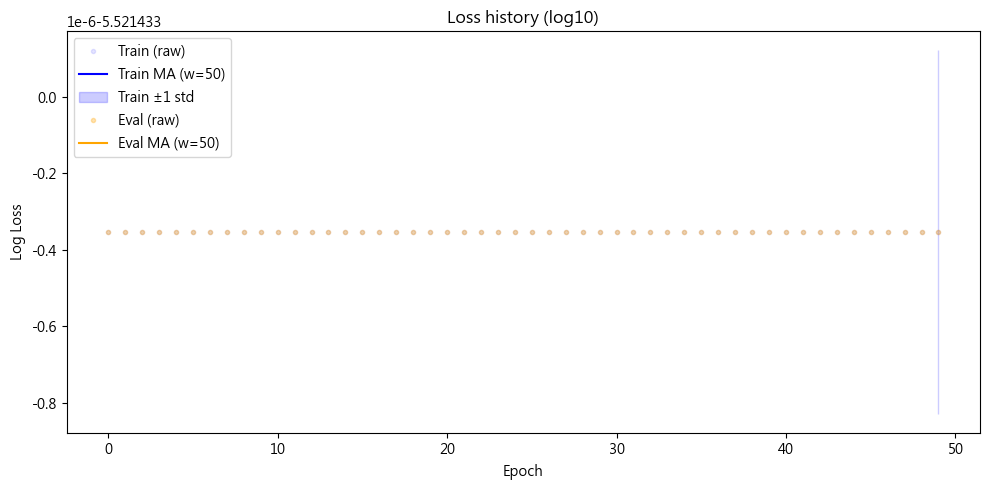

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


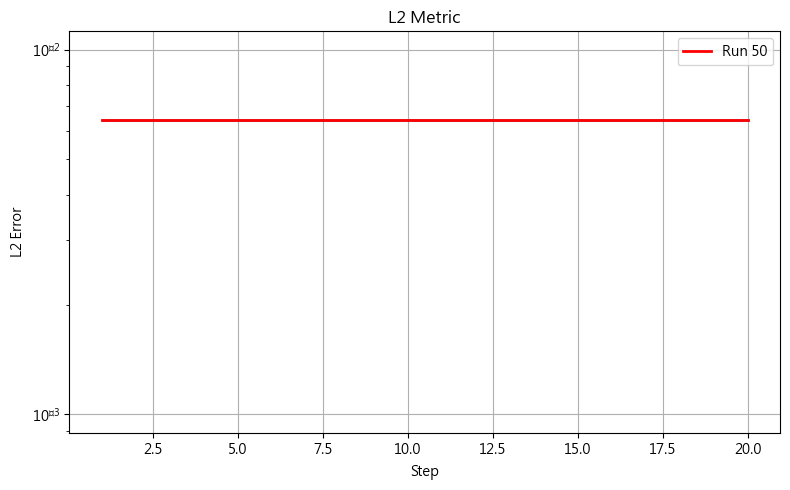

train epoch


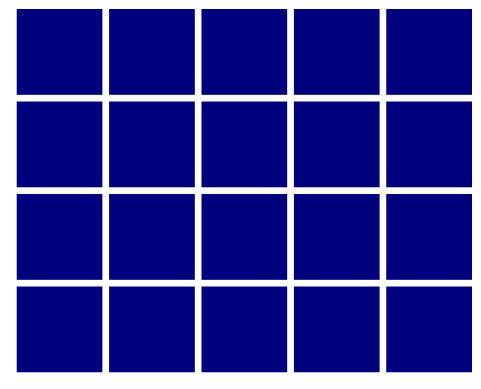

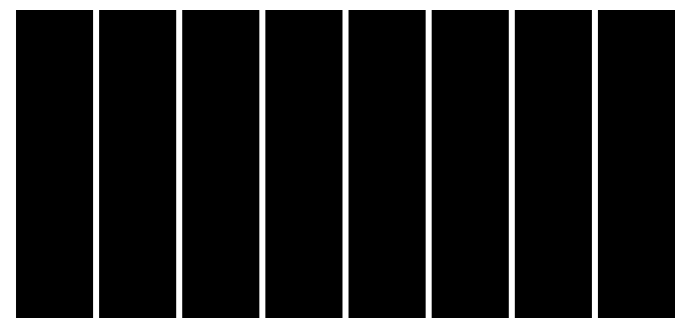

Training Epochs:   2%|▏         | 49/2000 [00:22<14:56,  2.18it/s]


ValueError: zero-size array to reduction operation minimum which has no identity

In [111]:
import json
import traceback
import os
import torch
import gc  # Python garbage collector

for run_id in range(50):
    remove_empty_dirs(r"C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA")
    # try:
    cfg = resolve_list_options(CONFIG, OPTIONS_PATHS)
    print(f"Run {run_id}:\n{cfg}")

    model = CAModel(cfg).to(DEVICE)
    optimizer = Optimizer.Adam(model.parameters(), lr=cfg["optim"]["lr"])
    lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    model_path = get_output_path()

    run_training(
        cfg,
        model,
        optimizer,
        loss_fn=custom_loss,
        metric_fn=acc_metric,
        lr_sched=lr_sched,
        output_path=model_path,
    )

    # 確保目錄存在再寫入
    os.makedirs(model_path, exist_ok=True)
    config_file_path = os.path.join(model_path, "config.json")
    with open(config_file_path, "w") as f:
        json.dump(cfg, f, indent=4)

    # except Exception as e:
    #     log_file = f"{model_path}/training_error.log"
    #     with open(log_file, "a") as log_f:
    #         log_f.write(f"Run {run_id} failed:\n")
    #         log_f.write(traceback.format_exc())
    #         log_f.write("\n" + "-"*80 + "\n")
    #     print(f"Run {run_id} failed. See {log_file} for details.")

    # finally:
    #     # -----------------------------
    #     # 釋放 GPU 記憶體
    #     # -----------------------------
    #     del model
    #     del optimizer
    #     del lr_sched
    #     torch.cuda.empty_cache()

    #     # -----------------------------
    #     # 釋放 Python 物件
    #     # -----------------------------
    #     gc.collect()


# After training

## viz pngs

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_all_png(root_dir):
    png_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for f in filenames:
            if f.lower().endswith(".png"):
                png_files.append(os.path.join(dirpath, f))

    if not png_files:
        print("No PNG files found.")
        return

    for img_path in png_files:
        print(f"Showing {img_path}")
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.relpath(img_path, root_dir))  # 不顯示 root_dir 之前的路徑
        plt.show()

# 使用範例
show_all_png(r"C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\outputs")


# test model

In [ ]:
import torch
import numpy as np
import os
import imageio
from PIL import Image  # 用來 resize

output_dir = "temp_frames"
os.makedirs(output_dir, exist_ok=True)

# --- 初始化資料 ---
Y_batch = create_epoch_pool(mode="eval").to(DEVICE)  # [1, 32, 64, 64]
X_batch = init_X(Y_batch)  # [batch, channel, H, W]

# 假設模型已經載入並設定 eval
load_model = CAModel(channel_n=CHANNELS).to(DEVICE)
load_model.load_state_dict(torch.load(f"{model_path}/model.pth"))
load_model.eval()

rollout_steps = 50
frames = []
target_size = (1024, 1024)  # (W, H)

for t in range(rollout_steps):
    # 每步 rollout
    X_batch = load_model(X_batch, n_times=1)

    # 取第一個 batch 的前三個 channel作 RGB
    x_np = X_batch[0, 4:7].detach().cpu().numpy()  # shape: [3, H, W]
    frame = np.transpose(x_np, (1, 2, 0))         # shape: [H, W, 3]
    frame = np.clip(frame, 0, 1)                  # 確保值在 0~1
    frame_uint8 = (frame * 255).astype(np.uint8)

    # resize
    img = Image.fromarray(frame_uint8)
    img = img.resize(target_size, resample=Image.BILINEAR)
    frame_resized = np.array(img)

    # 選擇是否存單張 PNG
    frame_path = os.path.join(output_dir, f"{t:03d}.png")
    imageio.imwrite(frame_path, frame_resized)

    # 累積成影片幀
    frames.append(frame_resized)

# 儲存成 mp4
video_path = f"{model_path}/output.mp4"
imageio.mimsave(video_path, frames, fps=3)
print("Saved mp4:", video_path)


TypeError: create_epoch_pool() missing 1 required positional argument: 'config'